# Importing packages and establishing a connection with Reddit API

In [237]:
import praw
import config_reddit
import json
from os import path
import os
import numpy as np
from textblob import TextBlob


reddit = praw.Reddit(user_agent=f"Exploration script by /u/{config_reddit.user_name}",
                     client_id=config_reddit.app_id,
                     client_secret=config_reddit.app_secret)

reddit.read_only

True

# Collecting Data From Reddit

In [238]:
# I am going to analyze the subreddit r/worldcup/ - https://www.reddit.com/r/worldcup/
# since the is the biggest football event in the world and is happening this year.
query_subreddit = 'worldcup'

# Number of posts and Comments
nposts = 50
ncomments = 15

# Collecting posts_ids
post_ids = []
subreddit = reddit.subreddit(query_subreddit)
for p in subreddit.hot(limit = nposts):
    post_ids.append(p.id)

len(post_ids)

50

In [239]:
# Showing an example of a ramdon post from the data collected.
post_details = reddit.submission(id = post_ids[0])

print(f"Title: {post_details.title} \n")
print(f"Selftext: {post_details.selftext}")

Title: TRAVEL MEGATHREAD 

Selftext: All things travel related. Any posts/questions/comments outside of this thread regarding Tickets, Accommodations, etc. will be removed!


In [240]:
# Collect post data
def collect_post_data(post_id, ncomments, reddit):
    psubm = reddit.submission(id = post_id)
    pdata = {'id': post_id, 'title': psubm.title, 'text': psubm.selftext}
    
    # collect first- and second-level comments
    pcomm = []
    psubcomm = []
    psubm.comments.replace_more(limit = ncomments)
    for top_comment in psubm.comments:
        pcomm.append(top_comment.body)
        for lev2_comment in top_comment.replies:
            psubcomm.append(lev2_comment.body)
    
    # assemble the data together
    pdata['comments_lev1'] = pcomm
    pdata['comments_lev2'] = psubcomm
    
    return pdata

In [241]:
# Collecting information for each post
posts_all = [collect_post_data(pid, ncomments, reddit) for pid in post_ids]

In [242]:
# save collected data to json file
file_out = f"raw_post_comment_data.json"
with open(file_out, mode='w') as f:
    f.write(json.dumps(posts_all, indent=2))

# Analysis of World Cup posts on Reddit

In [243]:
#Importing packages
import html
import string
import re
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.collocations import *
from wordcloud import WordCloud
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

In [ ]:
# Import json file with data collected
fjson = 'raw_post_comment_data.json'

# read json file with collected posts and comments
with open(fjson) as file:
    data = json.load(file)
    
print(f"""The file has {len(data)} posts
One example from the data is the post below: \n""")

data[0]

In [245]:
# Creating a DataFrame with the titles of the posts
df_posts = pd.DataFrame([p['title'] for p in data], columns=['title'])
df_posts

,title
0,TRAVEL MEGATHREAD
1,I am drawing every single sticker from the new...
2,"The results are in, group H is eliminated! Thu..."
3,GUESS THE BADGES INTERNATIONAL TEAMS
4,What's your shout for the most underrated Worl...
5,Stadium Guide - Day 1 (21-11-2022)
6,Idea to meet people going to world cup?
7,2006 World Cup: Ukraine defeats Saudi Arabia 4...
8,My fantasy world cup champion
9,How likely is it Chile will successfully appea...


In [246]:
# Adding columns to the title DataFrame, like the comments and subcomments
df_posts['post_id'] = [p['id'] for p in data] # Adding the column post_id to the DataFrame through a loop
df_posts['text'] = [p['text'] for p in data] # Adding the column text to the the DataFrame through a loop
df_posts['comments_lev1'] = [' '.join(p['comments_lev1']) for p in data] # Adding the column comment to the DataFrame
df_posts['comments_lev2'] = [' '.join(p['comments_lev2']) for p in data] # Adding the column subcomment to the DataFrame
df_posts


,title,post_id,text,comments_lev1,comments_lev2
0,TRAVEL MEGATHREAD,tmupei,All things travel related. Any posts/questions...,This was the reply I received when I wrote to ...,"I got this reply too, like if they told us thi..."
1,I am drawing every single sticker from the new...,wbaxia,,Great idea! How many are there and how many ha...,I have done just 60 yet and there is gonna be ...
2,"The results are in, group H is eliminated! Thu...",waxxm3,,What do you know about bias?\n\n/s Wales and I...,We did. And B remains. Making it the *least* b...
3,GUESS THE BADGES INTERNATIONAL TEAMS,wbitr6,,,
4,What's your shout for the most underrated Worl...,wb1k0h,I found this [one football article](https://on...,Joe Cole against Sweden or Maxi against Mexico...,"Oh man, Maxi’s goal was amazing! Tim was great..."
5,Stadium Guide - Day 1 (21-11-2022),wbifze,,Buses will depart from Free Zone Station for S...,
6,Idea to meet people going to world cup?,wb81gz,Hey guys I’m going to the World Cup and though...,Hi,
7,2006 World Cup: Ukraine defeats Saudi Arabia 4...,wat3jb,,Saudi always gets the shit kicked out of them,Best of the worst
8,My fantasy world cup champion,wbf5t8,1930 Uruguay\n\n1934 Czechoslovakia\n\n1938 It...,,
9,How likely is it Chile will successfully appea...,wapo51,,"It won't happen, as far as i know Ecuador will...",Yea so many Ecuadorians have probably all boug...


In [247]:
# Cleaning the text with the function text_clean
stop_words = set(stopwords.words('english'))

# Adding stop_words to the list
stop_words.add('gon')
stop_words.add('na')
stop_words.add('bitch')
stop_words.add('world')
stop_words.add('cup')
stop_words.add('u')
stop_words.add('got')
stop_words.add('etc')
stop_words.add('im')
stop_words.add('v')
print(stop_words)

def text_cleanup(s):
    s_unesc = html.unescape(re.sub(r"http\S+", "", re.sub('\n+', ' ', s)))
    s_noemoji = s_unesc.encode('ascii', 'ignore').decode('ascii')
    # normalize to lowercase and tokenize
    wt = word_tokenize(s_noemoji.lower())
    
    # filter word-tokens
    wt_filt = [w for w in wt if (w not in stop_words) and (w not in string.punctuation) and (w.isalnum())]
    
    # return clean string
    return ' '.join(wt_filt)

{'because', 'now', 'u', 'can', 'if', 'the', 'shouldn', 'ours', 'as', 'all', 'was', 'or', 'gon', 'during', 'who', "didn't", 'im', 'that', 'for', 've', 'but', 'y', 'got', 'had', "should've", 'whom', 'should', "doesn't", 'then', "shouldn't", 'no', 'just', 'above', 'him', 'its', 'by', 'there', 'between', 'herself', "you'll", 'through', "you've", 'hers', 'itself', 'down', 'when', 'couldn', 'na', 'why', 'in', "shan't", 'doesn', 'what', "you'd", 'under', 'here', 'o', "hadn't", 'more', 'out', "that'll", 'over', 'etc', 'off', 'yourself', 'mustn', 'don', 't', 'them', "wasn't", 'd', 'about', 'very', 'only', 'is', 'at', 'have', 'he', 'into', 'won', 'been', 'both', 'than', 'those', 'did', "isn't", "couldn't", 'own', 'weren', 'some', "needn't", 'with', 'we', "she's", 'were', 'where', 'until', 'below', 'while', 'each', 'doing', "mightn't", 'my', 'himself', 'her', 'haven', 'too', 'so', "aren't", 'most', 'world', 'an', 'our', 'ourselves', "you're", 'has', 'be', 's', 'against', 'will', 'needn', 'wouldn'

In [248]:
# Adding a column to the DataFrame with the cleaned text
df_posts['text_clean'] = (df_posts['text'] + df_posts['comments_lev1'] + df_posts['comments_lev2']).apply(text_cleanup)
df_posts

# Showing one example of the data.
df_posts['text_clean']


0     things travel related outside thread regarding...
1     great idea many many done release progress wee...
2     know bias wales iran really talented teams see...
3                                                      
4     found one football article thought missing ama...
5     buses depart free zone station senegal vs neth...
6     hey guys going thought cool experienced people...
7          saudi always gets shit kicked thembest worst
8     1930 uruguay 1934 czechoslovakia 1938 italy 19...
9     wo happen far know ecuador play wc matter conc...
10                                                     
11    bbc football daily football weekly bbc night d...
12    tough summer without wc docket ive passed bore...
13    mods pretty non existent quality content sub r...
14    stupid b b b b definitely group b ultimate rem...
15    belgium germany practicing social distancing b...
16    hey guys currently looking english interviews ...
17    tf e survive long 2014 people japan side s

In [249]:
# Adding Sentiment Analysis
def sentim_polarity(s):
    return TextBlob(s).sentiment.polarity

def sentim_subject(s):
    return TextBlob(s).sentiment.subjectivity

df_posts['polarity'] = df_posts['text_clean'].apply(sentim_polarity)
df_posts['subjectivity'] = df_posts['text_clean'].apply(sentim_subject)


# Finding examples of comments with a specific string.
df_string = df_posts[df_posts['text_clean'].str.contains('brazil')]
df_string

,title,post_id,text,comments_lev1,comments_lev2,text_clean,polarity,subjectivity
0,TRAVEL MEGATHREAD,tmupei,All things travel related. Any posts/questions...,This was the reply I received when I wrote to ...,"I got this reply too, like if they told us thi...",things travel related outside thread regarding...,0.112418,0.468110
8,My fantasy world cup champion,wbf5t8,1930 Uruguay\n\n1934 Czechoslovakia\n\n1938 It...,,,1930 uruguay 1934 czechoslovakia 1938 italy 19...,0.000000,0.000000
15,Teams Home Base Camps Qatar,w8n20q,,Belgium and Germany are practicing social dist...,Those Belgians are [full of Monkeypox!](https:...,belgium germany practicing social distancing b...,0.231845,0.598837
18,Why do people think that Argentina cheated aga...,w8eh9o,I don't understand why people think that Argen...,The issue is not that Argentina couldn't beat ...,I don't really think that the government had a...,understand people think argentina cheated hone...,0.127361,0.435417
29,"Round 3: Completely forgot about it, but here ...",w3gruk,,"As someone who is neither British or American,...",As a neutral England is an exciting team to wa...,someone neither british american b boring engl...,0.079706,0.453758
31,"People from Sweden, how is the 1958 generation...",w2sa3s,"Being Brazilian, I'm surprised I never see any...",A world cup win would have been nice for sure ...,,brazilian surprised never see anything related...,0.124024,0.486680
32,FIFA World Cup 2022 Monte Carlo Sim,w1fkhf,,I wonder what these simulations were for Costa...,The current SPI values are from FiveThirtyEigh...,wonder simulations costa rica 2014 korea seneg...,0.180643,0.475944
33,WorldCup,w11she,I Gotta Quick Questions Where do You guys thin...,Make it out of their group? Sure. Win the Worl...,Agreed. At best I think Senegal can get 3rd. I...,ta quick questions guys think senegal make gro...,0.233314,0.551372
34,"I live in Houston, I would like to attend atle...",w0w3sr,,It's hard to really say 4 years out. Tickets v...,Locally our news station recently stated our c...,hard really say 4 years tickets vary price cat...,0.042503,0.543194
37,Saudi Arabia will be key in Group C,w04u5e,"Argentina should advance with 9 points, so it’...",Not to underestimate Poland but I feel like so...,"This applies to every major team, Germany fini...",argentina advance 9 points mexico poland decid...,0.079431,0.462581


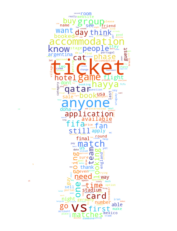

<Figure size 576x576 with 0 Axes>

In [255]:
# WordCloud of the most common words
text_combined = ' '.join(df_posts['text_clean'])

#Creating a mask
d = path.dirname(__file__) if "__file__" in locals() else os.getcwd()
mask = np.array(Image.open(path.join(d, "WorldCupTrophy.png")))

#WordCloud of all words
wc = WordCloud(width=3200, height=1600, max_font_size=200, mask = mask, background_color = 'white', colormap = 'turbo_r', collocations=False).generate(text_combined)
plt.axis("off")
plt.imshow(wc, interpolation="bilinear")
plt.figure(figsize=(8,8), facecolor = 'k')
plt.show()


               count
keyword             
ticket           663
game             247
one              183
accommodation    179
qatar            152
anyone           140
match            135
people           132
need             124
day              122
group            117
hayya card       115
fifa             113
team             113
matches          104
think            101
going             97
time              91
know              89
want              89
looking           88
anyone know       86
hotel             86
go                84
still             83
see               78
available         75
flight            74
way               70
book              68


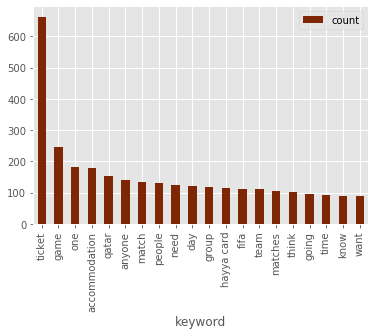

In [251]:
# Listing and counting the key words
kwords = WordCloud().process_text(text_combined)
kwords_df = pd.DataFrame(list(kwords.items()), 
                         columns = ['keyword', 'count']).set_index('keyword').sort_values(by = "count", 
                         ascending = False)

print(kwords_df.head(30))


# Top 20 words
%matplotlib inline
kwords_df.sort_values(by='count', ascending=False).head(20).plot.bar(colormap = 'Oranges_r')
plt.show()

In [252]:
# Finding Bigrams
bigram_measures = nltk.collocations.BigramAssocMeasures()
bigram_finder = BigramCollocationFinder.from_documents([d.split() for d in df_posts['text_clean']])

# Listing the Bigrams by frequency
bigram_freq = list(bigram_finder.ngram_fd.items())

# Transforming the list into a DataFrame
df_freq = pd.DataFrame([(' '.join(k), v) for k,v in bigram_freq], columns=['keyphrase', 'count'])
df_freq.sort_values(by='count', ascending=False, inplace=True)
df_freq.set_index('keyphrase', inplace = True)

# Top 20 Bigrams
df_freq.head(25)

,count
keyphrase,
hayya card,111
anyone know,80
cat 2,39
2 tickets,39
group stage,39
ticket application,32
portugal vs,30
round 16,30
get tickets,29


['Solarize_Light2', '_classic_test_patch', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark', 'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'tableau-colorblind10']


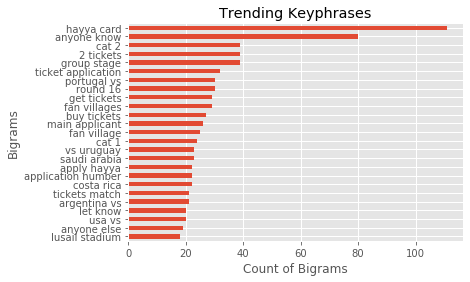

In [253]:
print(plt.style.available)

# Ploting Top 20 Bigrams
plt.style.use('ggplot')

# render a horizontal bar graph
df_freq.head(25).sort_values(by='count').plot(kind = 'barh')
plt.title('Trending Keyphrases')
plt.ylabel('Bigrams')
plt.xlabel('Count of Bigrams')
plt.legend().set_visible(False)
plt.show()

In [254]:
# Analysing most commong words and Bigrams Sentiments*
# *Including Brazil because it is my country and one of the favorites to win the World Cup
keywords_analysis = ['hayya card', 'tickets' , 'group stage', '2 tickets', 'brazil']
keywords_analysis_df = pd.DataFrame(keywords_analysis, 
                                    columns = ['KeyWords'])

# Defining the function to analyze the sentiment on the keywords
def words_sentiment(w):
    return df_posts[df_posts['text_clean'].str.contains(w)]['polarity'].mean()

# Keywords sentiment comparison
keywords_analysis_df['average_sentiment'] = keywords_analysis_df ['KeyWords'].apply(words_sentiment)
keywords_analysis_df


,KeyWords,average_sentiment
0,hayya card,0.156209
1,tickets,0.064814
2,group stage,0.025494
3,2 tickets,0.112418
4,brazil,0.115084


# Report



- Pedro Henrique Schaidt Andrade 
- Social Media Analytics    
- Professors: Pavel Paramonov and Beau Giannini                                                                                  

The idea of this analysis was to get an idea of the trending topics regarding the World Cup in Qatar, which is happening this year in November/December. Using the concepts and technical skills we learned in class, through Python Programming Language and Analysis, I could access Reddit's API (Step 1) and collect data on the hottest posts on the 'worldculp' subreddit - https://www.reddit.com/r/worldcup/ (Step 2).

Setting some parameters like the number of posts, comments and subcomments, we collected the data and saved it in a json file, that was letter read using Python, so I could perform the analysis (Step 3). On this stage, I structured the data collected into a data frame using pandas and performed a text cleaning using a user defined function (text_clean). 

Analyzing then the new cleaned text after adding some other stop words to the list created, I could see that the most frequent used words and bigrams (keyphrases) were related to tickets, accommodations in Qatar (hotels, fan villages). Reddit is being used as a marketplace for tickets to the 2022 World Cup, where users are trying to find other users who are selling or buying game tickets for specific games of countries like Uruguay, Saudi Arabia, Argentina, Costa Rica, US. Interesting to notice is that most of those countries are not really traditional or top ranked teams (except Argentine or Uruguay) so through this we can make sense of the location of some users.

Another trending topic is the Hayya Card, which is the official Fan ID of the World Cup. Users are interested on getting more information on the application process, or even buying cards through Reddit. What is interesting to notice is that when analyzing the word Hayya by itself, it can mislead you into another insight. Hayya is the name of the World Cup theme song, so using the Bigram function was crucial to get a context of the word.

I also included a text sentiment analysis on the keywords from the posts. Words like Hayya Card, Tickets, Group Stage, Brazil tend to have a slightly positive sentiment. To posts, I used the sentiment analysis 'polarity' and 'subjectivity' and added the columns to the data frame.

World Cup game tickets are hard to get, being the process very long and you must count with a little bit of luck, since it works in a lottery format. So, as conclusion of this analysis, the main takeaway is that if you are interested in going to the World Cup, Reddit and the subreddit 'worldcup' might be a good place to look for tickets, places to stay and other information related to the event. Also, if you are one of the lucky ones who were able to get the tickets but unfortunately can not go the event, Reddit is a good platform to find possible buyers and make extra money selling the tickets based on the high demand.

